In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import time
import math
sys.path.insert(0, '..')

from database.dataset import INBreast_Dataset
from general_utils.plots import plot_blobs2
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from mc_candidate_proposal.hdog_mc import HDoGCalcificationDetection
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.utils import get_center_bboxes
from metrics.metrics import get_tp_fp_fn

from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
from pathlib import Path

import warnings
import seaborn as sns
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Set the database

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=1.0, #max 315 pixels area
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    partitions = ['train'],
    n_jobs=-1,
    lesion_types=['calcification']
)

Morphology Detection

In [3]:
results_path = Path('/home/jseia/Desktop/ml-dl/results_detection/')
results_path.mkdir(exist_ok=True, parents=True)

In [37]:
# m_results_path = results_path / 'morphology'
# m_results_path.mkdir(exist_ok=True, parents=True)

# threshold = 0.97
# min_distance = 6
# area = 14
# results_morphology_complete = []
# for threshold in [0.93, 0.95, 0.97, 0.99]:
#     result_det = {}
#     res = []
#     for idx in tqdm(range(len(db)), total=len(db)):
#         rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'
#         Path('/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img').mkdir(exist_ok=True, parents=True)
#         md = MorphologyCalcificationDetection(rbd_path, threshold=threshold, min_distance=min_distance, area=area*area, store_intermediate=True)
#         case = db[idx]
#         image = case['img']
#         image_id = db.df.iloc[idx].img_id
#         radiouses = case['radiuses']
#         true_bboxes = db[idx]['lesion_bboxes']
#         start = time.time()
#         candidate_blobs = md.detect(image, image_id)
#         t = time.time() - start
#         tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0)
#         img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t, 'size': image.size, 'threshold': threshold}
#         res.append(img_res)
#         result_det[image_id] = {
#             'tp': tp, 'fp': fp, 'fn': fn, 'gt_d': gt_d, 'close_fp': close_fp
#         }
#     results_morphology = pd.DataFrame(res)
#     filename = f'md_th-{threshold}_mindist-{min_distance}_area-{area}'
#     results_morphology.to_csv(m_results_path/f'{filename}.csv')
#     with open(m_results_path/f'{filename}.pkl', 'wb') as f:
#         pickle.dump(result_det, f)
#     results_morphology_complete.append(results_morphology)
# results_morphology_complete = pd.concat(results_morphology_complete, ignore_index=True)
# filename = f'md_mindist-{min_distance}_area-{area}_TH'
# results_morphology_complete.to_csv(m_results_path/f'{filename}.csv')

100%|██████████| 106/106 [01:08<00:00,  1.55it/s]


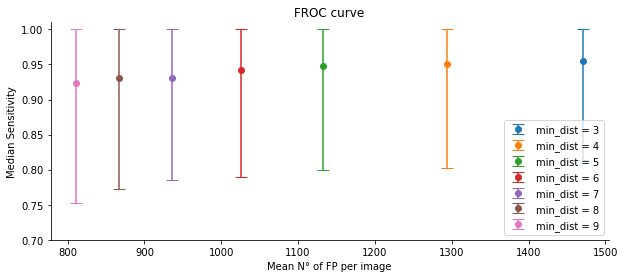

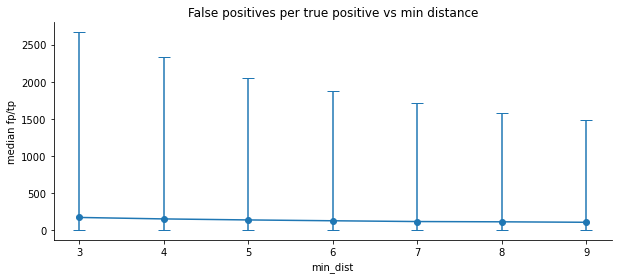

In [31]:
# filename = f'md_th-{threshold}_area-{area}_MIND'
# results_morphology_complete = pd.read_csv(m_results_path/f'{filename}.csv')
# results_morphology_complete['FPR'] = results_morphology_complete['FP'] / (results_morphology_complete['FP'] + results_morphology_complete['TP'])
# results_morphology_complete['sens'] = results_morphology_complete['TP'] / (results_morphology_complete['TP'] + results_morphology_complete['FN'])
# results_morphology_complete['fp_per_tp'] = results_morphology_complete['FP'] / (results_morphology_complete['TP'])

# cmap = plt.get_cmap("tab10")

# plt.figure(figsize=(10,4))
# for i in results_morphology_complete.min_distance.unique():
#     subset = results_morphology_complete.loc[results_morphology_complete.min_distance == i]
#     # sens = subset['TP'].sum() / (subset['TP'].sum() + subset['FN'].sum())
#     sens = subset['sens'].median()
#     sens_min = np.quantile(subset.sens.values, 0.25)
#     sens_max = np.quantile(subset.sens.values, 0.75)
#     mfpi = subset['FP'].sum() / len(subset)
#     plt.errorbar(mfpi, sens, yerr=[[sens - sens_min], [sens_max - sens]], fmt='o', label=f'min_dist = {i}',capsize=6)
# plt.ylim([0.7,1.01])
# plt.ylabel('Median Sensitivity')
# plt.xlabel('Mean N° of FP per image')
# plt.title('FROC curve')
# plt.legend()
# sns.despine()
# plt.show()

# fp_per_tps = []
# m_d = []
# plt.figure(figsize=(10,4))
# for i in results_morphology_complete.min_distance.unique():
#     selection = (results_morphology_complete.min_distance == i) & (results_morphology_complete.TP != 0)
#     subset = results_morphology_complete.loc[selection]
#     # fp_per_tp_min = np.quantile(subset['fp_per_tp'].values, 0.25)
#     # fp_per_tp_max = np.quantile(subset['fp_per_tp'].values, 0.75)
#     fp_per_tp_min = subset['fp_per_tp'].min()
#     fp_per_tp_max = subset['fp_per_tp'].max()
#     fp_per_tp = np.median(subset['fp_per_tp'])
#     fp_per_tps.append(fp_per_tp)
#     m_d.append(i)
#     plt.errorbar(i, fp_per_tp, yerr=[[fp_per_tp-fp_per_tp_min], [fp_per_tp_max-fp_per_tp]], fmt='o', color=cmap(0), capsize=6)
# plt.plot(m_d, fp_per_tps, color=cmap(0))
# plt.ylabel('median fp/tp')
# plt.xlabel('min_dist')
# plt.title('False positives per true positive vs min distance')
# sns.despine()
# plt.show()

# # fprs = []
# # m_d = []
# # plt.figure(figsize=(15,6))
# # for i in results_morphology_complete.min_distance.unique():
# #     selection = (results_morphology_complete.min_distance == i) & (results_morphology_complete.TP != 0)
# #     subset = results_morphology_complete.loc[selection]
# #     fpr_min = np.quantile(subset['FPR'].values, 0.25)
# #     fpr_max = np.quantile(subset['FPR'].values, 0.75)
# #     fpr = np.median(subset['FPR'])
# #     fprs.append(fpr)
# #     m_d.append(i) 
# #     plt.errorbar(i, fpr, yerr=[[fpr-fpr_min], [fpr_max-fpr]], fmt='o', color=cmap(0), capsize=4)
# # plt.plot(m_d, fprs, color=cmap(0))
# # plt.ylabel('median FPR')
# # plt.xlabel('min_dist')
# # plt.title('False positives per true positive vs min distance')
# # sns.despine()
# # plt.show()



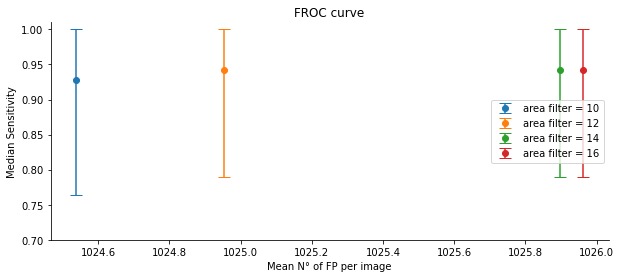

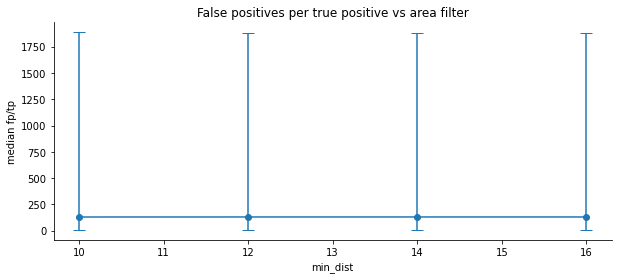

In [36]:
# filename = f'md_th-{threshold}_mindist-{min_distance}_AREA'
# results_morphology_complete = pd.read_csv(m_results_path/f'{filename}.csv')
# results_morphology_complete['FPR'] = results_morphology_complete['FP'] / (results_morphology_complete['FP'] + results_morphology_complete['TP'])
# results_morphology_complete['sens'] = results_morphology_complete['TP'] / (results_morphology_complete['TP'] + results_morphology_complete['FN'])
# results_morphology_complete['fp_per_tp'] = results_morphology_complete['FP'] / (results_morphology_complete['TP'])

# cmap = plt.get_cmap("tab10")

# plt.figure(figsize=(10,4))
# for i in results_morphology_complete.area.unique():
#     subset = results_morphology_complete.loc[results_morphology_complete.area == i]
#     # sens = subset['TP'].sum() / (subset['TP'].sum() + subset['FN'].sum())
#     sens = subset['sens'].median()
#     sens_min = np.quantile(subset.sens.values, 0.25)
#     sens_max = np.quantile(subset.sens.values, 0.75)
#     mfpi = subset['FP'].sum() / len(subset)
#     plt.errorbar(mfpi, sens, yerr=[[sens - sens_min], [sens_max - sens]], fmt='o', label=f'area filter = {i}',capsize=6)
# plt.ylim([0.7,1.01])
# plt.ylabel('Median Sensitivity')
# plt.xlabel('Mean N° of FP per image')
# plt.title('FROC curve')
# plt.legend()
# sns.despine()
# plt.show()

# fp_per_tps = []
# m_d = []
# plt.figure(figsize=(10,4))
# for i in results_morphology_complete.area.unique():
#     selection = (results_morphology_complete.area == i) & (results_morphology_complete.TP != 0)
#     subset = results_morphology_complete.loc[selection]
#     # fp_per_tp_min = np.quantile(subset['fp_per_tp'].values, 0.25)
#     # fp_per_tp_max = np.quantile(subset['fp_per_tp'].values, 0.75)
#     fp_per_tp_min = subset['fp_per_tp'].min()
#     fp_per_tp_max = subset['fp_per_tp'].max()
#     fp_per_tp = np.median(subset['fp_per_tp'])
#     fp_per_tps.append(fp_per_tp)
#     m_d.append(i)
#     plt.errorbar(i, fp_per_tp, yerr=[[fp_per_tp-fp_per_tp_min], [fp_per_tp_max-fp_per_tp]], fmt='o', color=cmap(0), capsize=6)
# plt.plot(m_d, fp_per_tps, color=cmap(0))
# plt.ylabel('median fp/tp')
# plt.xlabel('min_dist')
# plt.title('False positives per true positive vs area filter')
# sns.despine()
# plt.show()

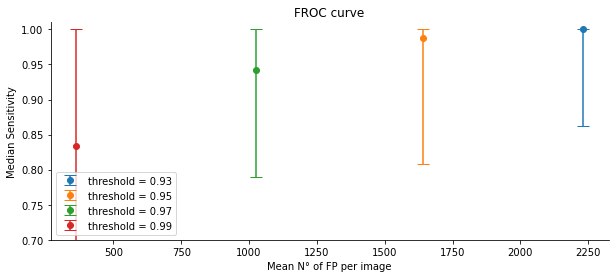

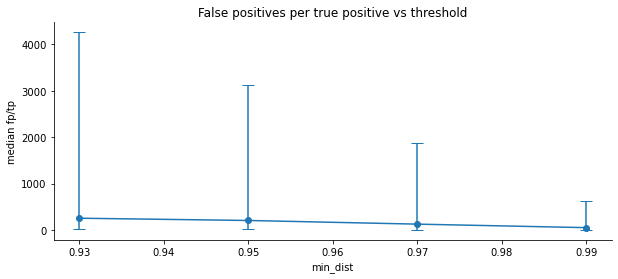

In [38]:
# filename = f'md_mindist-{min_distance}_area-{area}_TH'
# results_morphology_complete = pd.read_csv(m_results_path/f'{filename}.csv')
# results_morphology_complete['FPR'] = results_morphology_complete['FP'] / (results_morphology_complete['FP'] + results_morphology_complete['TP'])
# results_morphology_complete['sens'] = results_morphology_complete['TP'] / (results_morphology_complete['TP'] + results_morphology_complete['FN'])
# results_morphology_complete['fp_per_tp'] = results_morphology_complete['FP'] / (results_morphology_complete['TP'])

# cmap = plt.get_cmap("tab10")

# plt.figure(figsize=(10,4))
# for i in results_morphology_complete.threshold.unique():
#     subset = results_morphology_complete.loc[results_morphology_complete.threshold == i]
#     # sens = subset['TP'].sum() / (subset['TP'].sum() + subset['FN'].sum())
#     sens = subset['sens'].median()
#     sens_min = np.quantile(subset.sens.values, 0.25)
#     sens_max = np.quantile(subset.sens.values, 0.75)
#     mfpi = subset['FP'].sum() / len(subset)
#     plt.errorbar(mfpi, sens, yerr=[[sens - sens_min], [sens_max - sens]], fmt='o', label=f'threshold = {i}',capsize=6)
# plt.ylim([0.7,1.01])
# plt.ylabel('Median Sensitivity')
# plt.xlabel('Mean N° of FP per image')
# plt.title('FROC curve')
# plt.legend()
# sns.despine()
# plt.show()

# fp_per_tps = []
# m_d = []
# plt.figure(figsize=(10,4))
# for i in results_morphology_complete.threshold.unique():
#     selection = (results_morphology_complete.threshold == i) & (results_morphology_complete.TP != 0)
#     subset = results_morphology_complete.loc[selection]
#     # fp_per_tp_min = np.quantile(subset['fp_per_tp'].values, 0.25)
#     # fp_per_tp_max = np.quantile(subset['fp_per_tp'].values, 0.75)
#     fp_per_tp_min = subset['fp_per_tp'].min()
#     fp_per_tp_max = subset['fp_per_tp'].max()
#     fp_per_tp = np.median(subset['fp_per_tp'])
#     fp_per_tps.append(fp_per_tp)
#     m_d.append(i)
#     plt.errorbar(i, fp_per_tp, yerr=[[fp_per_tp-fp_per_tp_min], [fp_per_tp_max-fp_per_tp]], fmt='o', color=cmap(0), capsize=6)
# plt.plot(m_d, fp_per_tps, color=cmap(0))
# plt.ylabel('median fp/tp')
# plt.xlabel('min_dist')
# plt.title('False positives per true positive vs threshold')
# sns.despine()
# plt.show()

Morphology

In [ ]:
m_results_path = results_path / 'morphology'
m_results_path.mkdir(exist_ok=True, parents=True)

threshold = 0.97
min_distance = 6
area = 14
result_det = {}
res = []
for idx in tqdm(range(len(db)), total=len(db)):
    rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'
    Path('/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img').mkdir(exist_ok=True, parents=True)
    md = MorphologyCalcificationDetection(rbd_path, threshold=threshold, min_distance=min_distance, area=area*area, store_intermediate=True)
    case = db[idx]
    image = case['img']
    image_id = db.df.iloc[idx].img_id
    radiouses = case['radiuses']
    true_bboxes = db[idx]['lesion_bboxes']
    start = time.time()
    candidate_blobs = md.detect(image, image_id)
    t = time.time() - start
    tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0)
    img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t}
    res.append(img_res)
    result_det[image_id] = {
        'tp': tp, 'fp': fp, 'fn': fn, 'gt_d': gt_d, 'close_fp': close_fp
    }
results_morphology = pd.DataFrame(res)
filename = f'md_th-{threshold}_mindist-{min_distance}_area-{area}'
results_morphology.to_csv(m_results_path/f'{filename}.csv')
with open(m_results_path/f'{filename}.pkl', 'wb') as f:
    pickle.dump(result_det, f)

HDoG

In [7]:
hdog_results_path = results_path / 'HDoG'
hdog_results_path.mkdir(exist_ok=True, parents=True)

processed_imgs_path = '/home/jseia/Desktop/ml-dl/data/hdog_images'
detections_path = '/home/jseia/Desktop/ml-dl/data/hdog_detections'

# Default parameters
dog_parameters = {
    'min_sigma': 1,
    'max_sigma': 3,
    'n_scales': 20,
    'sigma_ratio': None,
    'dog_blob_th': 0.006,
    'dog_overlap': 0.2,
    'dog_min_dist': 0,
}

hessian_parameters = {
    'method': 'eigenval',
    'hessian_threshold': None,
    'hessian_th_divider': 300
}

res = []
result_det = {}

for idx in tqdm(range(len(db)), total=len(db)):
    hdogd = HDoGCalcificationDetection(dog_parameters, hessian_parameters, processed_imgs_path, detections_path)
    
    case = db[idx]
    image = case['img']
    image_id = db.df.iloc[idx].img_id
    radiouses = case['radiuses']
    true_bboxes = db[idx]['lesion_bboxes']

    start = time.time()
    detections, candidate_detections = hdogd.detect(
        db[idx]['img'], db.df.at[idx, 'img_id'], use_preprocessed=False, save_results=False
    )
    t = time.time() - start
    detections[:, 2] = detections[:, 2]*math.sqrt(2)

    # metrics
    tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, detections, 7, 0.0)
    img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t}
    res.append(img_res)
    result_det[image_id] = {
        'tp': tp, 'fp': fp, 'fn': fn, 'gt_d': gt_d, 'close_fp': close_fp
    }
results_hdog = pd.DataFrame(res)

ms = dog_parameters['min_sigma']
Ms = dog_parameters['max_sigma']
ns = dog_parameters['n_scales']
ns = dog_parameters['n_scales']
dth = dog_parameters['dog_blob_th']
dovp = dog_parameters['dog_overlap']
dmd = dog_parameters['dog_min_dist']
filename = f'md_ms-{ms}_Ms-{Ms}_ns-{ns}_dth-{dth}_dmd-{dmd}_'
results_hdog.to_csv(hdog_results_path/f'{filename}.csv')
with open(hdog_results_path/f'{filename}.pkl', 'wb') as f:
    pickle.dump(result_det, f)

Hough

In [6]:
hough_results_path = results_path / 'Hough'
hough_results_path.mkdir(exist_ok=True, parents=True)

dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50
erosion_iter = 20
erosion_size = 5

res = []
result_det = {}

for idx in tqdm(range(len(db))):
    hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path('/home/jseia/Desktop/ml-dl/data/hough'),
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)

    case = db[idx]
    image = case['img']
    image_id = db.df.iloc[idx].img_id
    radiouses = case['radiuses']
    true_bboxes = db[idx]['lesion_bboxes']

    start = time.time()
    _, h2_circles = hd.detect(
        image, image_id, load_processed_images=False, hough2=True)
    t = time.time() - start

    # metrics
    tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, h2_circles, 7, 0.0)
    img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t}
    res.append(img_res)
    result_det[image_id] = {
        'tp': tp, 'fp': fp, 'fn': fn, 'gt_d': gt_d, 'close_fp': close_fp
    }
results_hough = pd.DataFrame(res)
filename = f'hough_default'
results_hough.to_csv(hough_results_path/f'{filename}.csv')
with open(hough_results_path/f'{filename}.pkl', 'wb') as f:
    pickle.dump(result_det, f)

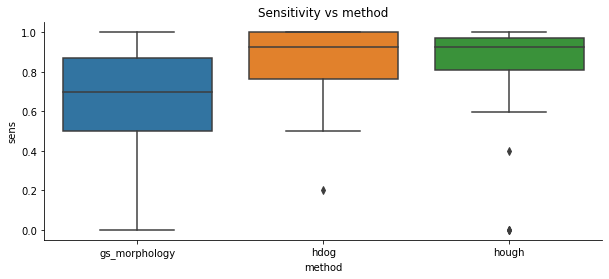

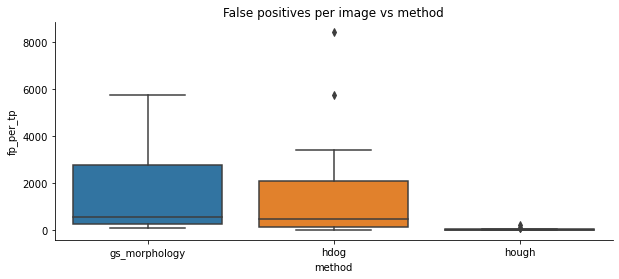

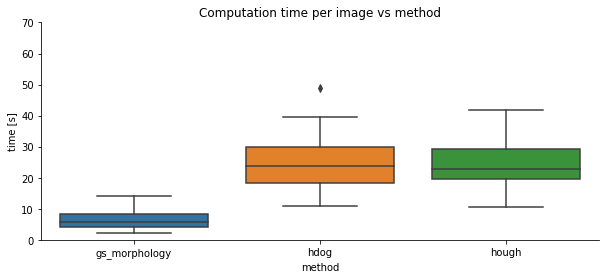

In [9]:
results_morphology = pd.read_csv('/home/jseia/Desktop/ml-dl/results_detection/morphology/dont_delete/md_th-0.97_mindist-6_area-14.csv')
results_morphology = results_morphology.loc[0:30,:]
results_morphology['method'] = 'gs_morphology'

results_hdog = pd.read_csv('/home/jseia/Desktop/ml-dl/results_detection/HDoG/md_ms-1_Ms-3_ns-20_dth-0.006_dmd-6_.csv')
results_hdog['method'] = 'hdog'

results_hough = pd.read_csv('/home/jseia/Desktop/ml-dl/results_detection/Hough/hough_default.csv')
results_hough = results_hough.loc[0:30,:]
results_hough['method'] = 'hough'

results = pd.concat([results_morphology, results_hdog, results_hough], ignore_index=True)
results['FPR'] = results['FP'] / (results['FP'] + results['TP'])
results['mfpi'] = (results['FP'] / len(results)).sum()
results['sens'] = results['TP'] / (results['TP'] + results['FN'])
results['fp_per_tp'] = results['FP'] / (results['TP'])

plt.figure(figsize=(10, 4))
plt.title('Sensitivity vs method')
sns.boxplot(data=results, x='method', y='sens')
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('False positives per image vs method')
sns.boxplot(data=results, x='method', y='fp_per_tp')
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Computation time per image vs method')
sns.boxplot(data=results, x='method', y='time')
sns.despine()
plt.ylabel('time [s]')
plt.ylim([0, 70])
plt.show()
